Here's a written out description of the model: https://docs.google.com/document/d/1X_D2o0lCNbUgJKiGdPwsoFBh_1zW8ypg9WNgQG3b_Lw/edit?usp=sharing

Rent data is taken from Housing and Urban Development Fair Market Rental cost of half of a 2 bedroom apartment: https://docs.google.com/spreadsheets/d/1PrOxEi02xqOWTSDg0o76y4KbUe4IXm2zKWLOWMBL8UY/edit?usp=sharing

### Usage Notes

- Need to define beta_rng even if h_0=0
- beta_rng and alpha_rng can be defined as
    - static (single num) or dynamic (list with min and max)
    - global (for all campuses) or local (specified for each campus)
    - current implementation only suppots one being dynamic per locality

In [1]:
### Time-independent alp_rng examples, same for beta_rng ###
# alp_rng = 0.06
# alp_rng = [0.01,0.1]
# alp_rng = [[0.01,0.1], [0.01,0.1], [0.01,0.1], [0.01,0.1], [0.01,0.1],
#            [0.01,0.1], [0.01,0.1], [0.01,0.1], [0.01,0.1], [0.01,0.1]]
### Time-dependent alp_rng exammples for 2 timesteps ###
# alp_rng = [0.126, 0.035]

In [2]:
# Imports
import numpy as np
import pandas as pd
from main import WageModel
from matplotlib import pyplot as plt
import os, sys
import csv
from matplotlib import cm

# Run Simulation

#### Parameterize model
Run this cell even if you're skipping to the analysis portion.

In [3]:
ucnames = ['UCM', 'UCR', 'UCD', 'UCLA', 'UCSD',     
           'UCB', 'UCI', 'UCSB', 'UCSC', 'UCSF']
reps = 1000   #Number of simulation replicas                    
tstep = 1   #Sim timestep, only tstep=1 year implemented so far
tfinal = 2   #Final timestep of sim
### Rents
rent_data = pd.read_csv('rent_data.csv')
meth = 'rent change skewed'   #Change rate calc method, only one implemented so far 
skew = -3   #Skew value for skewed-normal yearly rent change distribution
r = 0.3   #Target rent to income ratio, not used in current implementation
### Wages
rate_timeseries = False    #Set to True for time dependent rates, False for time independent rates
bw_0 = np.repeat(24.99e3,len(ucnames))   #Base wages
num_steps = 3.   #Number of experience steps
step_inc = 0.03   #Increase between steps
a = np.arange(1, 1+step_inc*(num_steps-1), step_inc)   #Experience step coefficients
stepwide_alp = False   #Apply increase to all steps (True) or just base (False)
alp_rng = [0.126, 0.035]   #Time-dependent alp_rng
### Stipends
h_0 = np.repeat(0, len(ucnames))   #Initial housing stipend
beta_rng = [0., 0.]   #Time-dependent beta_rng
### UC payout (payout calculation not implemented yet)
y_max = 8   #Highest grad student year
yf = np.array([2,4,5,6,y_max])   #Final year of given wage step
d = -0.06   #Dropout rate
y_grad = 3   #Year people start graduating
S_tot = 1   #Total number of students

#### Run the model

In [4]:
# Create csv for writing output
outfn = 'out.csv'
overwrite = True ### CAREFUL!
params = ['rep','t','k']
for i in range(len(a)):
    params.append('w_'+str(i))
params.append('h')
params.append('R')
if os.path.isfile(outfn) == True:
    if overwrite:
        os.remove(outfn)
    else:
        sys.exit('Set overwrite to True to overwrite existing output file')

# Run simulation
with open(outfn, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(params)
    for rep in range(reps):
        params = {'a':a, 'bw_0':bw_0, 'alp_rng':alp_rng, 'stepwide_alp':stepwide_alp,
                  'h_0':h_0, 'beta_rng':beta_rng, 'r':r, 'yf':yf, 'y_max':y_max, 'd':d,
                  'd':d, 'y_grad':y_grad, 'S_tot':S_tot, 'rent_data':rent_data, 'meth':meth,
                  'rep':rep, 'rate_timeseries':rate_timeseries, 'skew':skew}
        model = WageModel(**params)
        model.runsim(outfile=outfile, tstep=tstep, tfinal=tfinal, verbose=False)
%tb

No traceback available to show.


# Analysis

Note this doesn't account for the contract actually starting in early 2023 and ending in Fall 2025. It just assumes the wage and contract years overlap exactly. I don't think it makes a big difference. 

#### Plot the baseline income and rent per campus

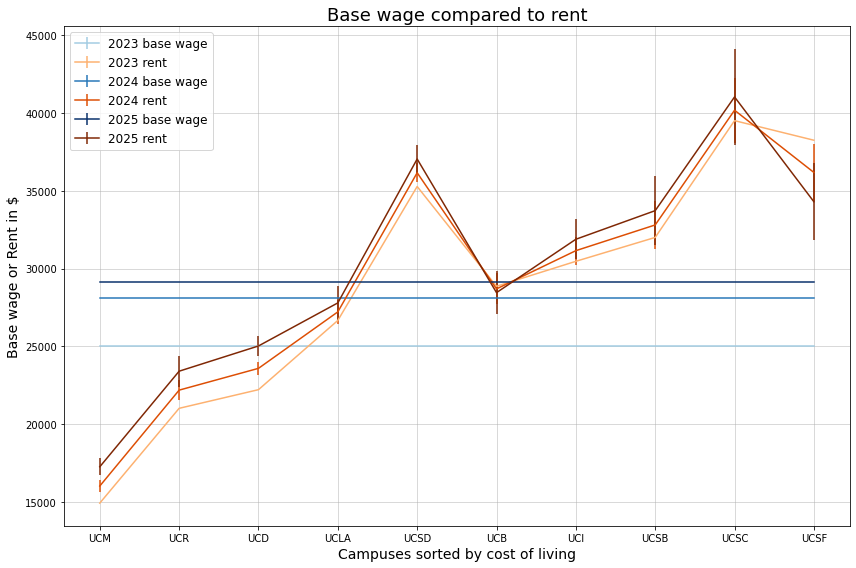

In [5]:
df = pd.read_csv('out.csv')
    
time = np.arange(0, tfinal+tstep, tstep)
y_0 = 2023 # Year contract begins

# An extremely naive way to simluate cost of living change
# current living wage data taken from MIT cost of living calculator
lw = np.array([34216. , 38812.8, 40934.4, 45531.2, 47299.2, 50460.8, 51833.6, 52665.6, 57075.2, 64084.8])
for t in range(len(time)):
    lw = lw * 1.05

fig = plt.figure(figsize=(12,8))
# fig = plt.figure(figsize=(10,6))
colmap = cm.get_cmap('Blues', 12)
Rcolmap = cm.get_cmap('Oranges', 12)
R_all = []
pct_change_avg_all = []
for i, t in enumerate(time):
    income_avgs = []
    income_stds = []
    R_avgs = []
    R_stds = []
    for k in range(len(bw_0)):
        df_sub = df[(df.t == t) & (df.k == k)]
        bw_avg, bw_std = np.mean(df_sub['w_0']), np.std(df_sub['w_0'])
        h_avg, h_std = np.mean(df_sub['h']), np.std(df_sub['h'])
        income_avg = bw_avg + h_avg
        income_avgs.append(income_avg)
        income_std = np.sqrt(bw_std**2 + h_std**2)
        income_stds.append(income_std)
        R_avg, R_std = np.mean(df_sub['R']), np.std(df_sub['R'])
        R_avgs.append(R_avg)
        R_stds.append(R_std)
#     print('R_avgs(t={}) = {}'.format(t,R_avgs))
    R_all.append(np.array(R_avgs))
    if t > 0:
        pct_change_avg = ((R_all[i]-R_all[i-1])/R_all[i-1])*100
#         print('pct_change_avg(t={}) = {}'.format(t, pct_change_avg))
        pct_change_avg_all.append(pct_change_avg)
#     if i == len(time)-1:   #Only plot the final timestep
    if True:   #Plot all timesteps
        plt.errorbar(ucnames,income_avgs,yerr=income_stds, 
                     label='{} base wage'.format(str(t+y_0)), c=colmap((i+1)/3))
        plt.errorbar(ucnames,R_avgs,yerr=R_stds, 
                     label='{} rent'.format(str(t+y_0)), c=Rcolmap((i+1)/3))
    #     plt.plot(ucnames,np.array(income_avgs)*0.3, ls='--', c=Rcolmap(i/3),
    #                 label='rent burden thresh year {}'.format(str(t)))

# plt.plot(ucnames,lw, c='red', label='Cost of living final year')
plt.grid(True,alpha=0.6)
plt.title('Base wage compared to rent', fontsize=18)
plt.ylabel('Base wage or Rent in $', fontsize=14)
plt.xlabel('Campuses sorted by cost of living', fontsize=14)
plt.tight_layout()
plt.legend(fontsize='large')
plt.savefig('UCpropsim.png', dpi=200, facecolor='white', transparent=False)
plt.show()

#### Plot average percent range change by campus for each timestep

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


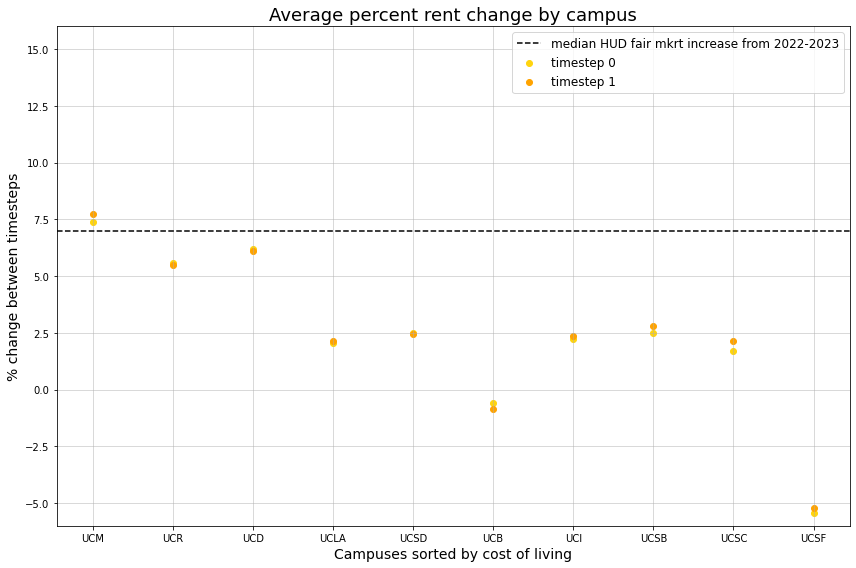

In [6]:
fig = plt.figure(figsize=(12,8))
Rcolmap = cm.get_cmap('Wistia', 12)
for i, pct_change in enumerate(pct_change_avg_all):
    plt.scatter(ucnames, pct_change, label="timestep {}".format(i), c=Rcolmap((i+1)/3))
plt.axhline(7, ls='--', c='black', label="median HUD fair mkrt increase from 2022-2023")
plt.grid(True,alpha=0.6)
plt.title('Average percent rent change by campus', fontsize=18)
plt.ylabel('% change between timesteps', fontsize=14)
plt.xlabel('Campuses sorted by cost of living', fontsize=14)
plt.ylim(-6,16)
plt.tight_layout()
plt.legend(fontsize='large')
plt.show()